## Combat harmonization

This script what it does is to run a harmonization of the data and leave it in the same exact format and place as the original publish_display_data. It is a very simple script that uses the `combat` function from the `combat` package. The script is as follows:


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import itertools 

# ignore warnings for easier plotting
import warnings
warnings.filterwarnings("ignore")
from load_data import load_data
from neuroCombat import neuroCombat

In [2]:
df_merged = load_data()

# covars and GROUP and SEX
# for GROUP, we need to convert them to number from 1 to len(GROUP.unique())
df_merged['CENTER_cat'] = pd.Categorical(df_merged['CENTER'])
list_of_centers = df_merged['CENTER_cat'].cat.categories.tolist()
df_merged['CENTER_cat'] = df_merged['CENTER_cat'].cat.codes + 1
print(list_of_centers)

df_merged['SEX_cat'] = pd.Categorical(df_merged['SEX'])
df_merged['SEX_cat'] = df_merged['SEX_cat'].cat.codes + 1

df_merged['GROUP_cat'] = pd.Categorical(df_merged['GROUP'])
df_merged['GROUP_cat'] = df_merged['GROUP_cat'].cat.codes + 1

covars = df_merged[["CENTER_cat", "SEX_cat", "GROUP_cat", "AGE"]]

print(covars)

Initial length: 730
disease
HC    216
MS    514
dtype: int64
QC N: 5
QC Y: 724
LONDON2: 27
['AMSTERDAM', 'CLINIC', 'LONDON', 'MAINZ', 'MILAN', 'NAPLES', 'OSLO']
     CENTER_cat  SEX_cat  GROUP_cat        AGE
0             2        1          4  39.240000
1             2        1          4  46.360000
2             2        1          4  67.440000
3             2        2          4  65.530000
4             2        1          4  50.140000
..          ...      ...        ...        ...
725           1        1          4  50.924025
726           1        1          5  49.686516
727           1        1          3  44.731006
728           1        1          4  48.821355
729           1        1          4  31.660507

[697 rows x 4 columns]


In [3]:
categorical_cols = ['SEX_cat', 'GROUP_cat']

# To specify the name of the variable that encodes for the scanner/batch covariate:
batch_col = "CENTER_cat"

# select only the following columns:
columns_to_combat = ['GM', 'GMF', 'WM', 'WMF', 'CSF', 'CSFF', 'LV', 'LVF', 'BPF', 'RDwm_mean', 'RDwm_std', 'RDlwm_mean', 'RDlwm_std', 'RDl_mean', 'RDl_std', 'RD_gm', 'RD_gmwm', 'FAwm_mean', 'FAwm_std', 'FAlwm_mean', 'FAlwm_std', 'FAl_mean', 'FAl_std', 'FA_gm', 'FA_gmwm', 'CC_Sag_area', 'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central', 'CC_Mid_Anterior', 'CC_Anterior', 'BrainSegVol', 'EstimatedTotalIntraCranialVol', 'Comm_ratio', 'SC_Corr_total', 'SC_Corr_intra_L', 'SC_Corr_intra_R', 'SC_L_avg_spl', 'SC_L_avg_eff', 'SC_R_avg_spl', 'SC_R_avg_eff', 'SC_avg_spl', 'SC_avg_eff', 'FC_Corr_total', 'FC_Corr_intra_L', 'FC_Corr_intra_R', 'Entropy_total', 'Entropy_L', 'Entropy_R', 'Integration_total', 'Integration_L', 'Integration_R', 'FC_L_avg_spl', 'FC_L_efficiency', 'FC_R_avg_spl', 'FC_R_efficiency', 'FC_avg_spl', 'FC_efficiency', 'SC_corr_whole', 'SC_corr_q4', 'FC_corr_whole', 'FC_corr_q1', 'FC_corr_q4', 'long_FCSC', 'SC_spl_full', 'SC_eff_full', 'FC_spl_full', 'FC_eff_full', 'FC_entropy_full', 'FC_integration_full', 'Full_CC', 'Comm_ratio_approx', 'CC_ratio_area', 'CC_Sag_area_sqrt', 'TIV_cubicroot']

data = df_merged[columns_to_combat]

print(data.shape)
print(covars.shape)

combat = neuroCombat(dat=data.T,
    covars=covars,
    batch_col=batch_col,
    categorical_cols=categorical_cols)


(697, 75)
(697, 4)
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


In [4]:
data_combat = combat["data"].T
estimates = combat["estimates"]

print(data_combat)
print(estimates.keys())

# Reassign the data to df_merged
df_merged[columns_to_combat] = data_combat

# save to disk
df_merged.to_csv("/home/gerard/VHIR/MAGNIMS_DEFINITIVE_RESULTS/df_merged_combat.csv", index=False)

[[6.28317544e+05 4.59095601e-01 4.16898963e+05 ... 2.12070150e-01
  1.32142127e+00 2.00312390e+00]
 [6.45236550e+05 4.68186583e-01 4.18180747e+05 ... 2.77411543e-01
  1.45473111e+00 2.01046718e+00]
 [6.08551618e+05 4.06156532e-01 3.88103389e+05 ... 2.82917916e-01
  1.45517876e+00 2.00108258e+00]
 ...
 [6.12576072e+05 4.27407158e-01 4.40883519e+05 ... 2.79948192e-01
  1.45184926e+00 2.00455502e+00]
 [6.36274543e+05 4.28278622e-01 4.98350676e+05 ... 2.35715868e-01
  1.38697254e+00 2.01487402e+00]
 [7.21941943e+05 4.42619169e-01 4.85862618e+05 ... 2.63711748e-01
  1.44387438e+00 2.02537642e+00]]
dict_keys(['gamma_hat', 'delta_hat', 'gamma_bar', 't2', 'a_prior', 'b_prior', 'batches', 'var.pooled', 'stand.mean', 'mod.mean', 'gamma.star', 'delta.star'])


In [5]:
print(estimates["gamma.star"].shape)

(7, 75)


(7, 75)
(7, 75)


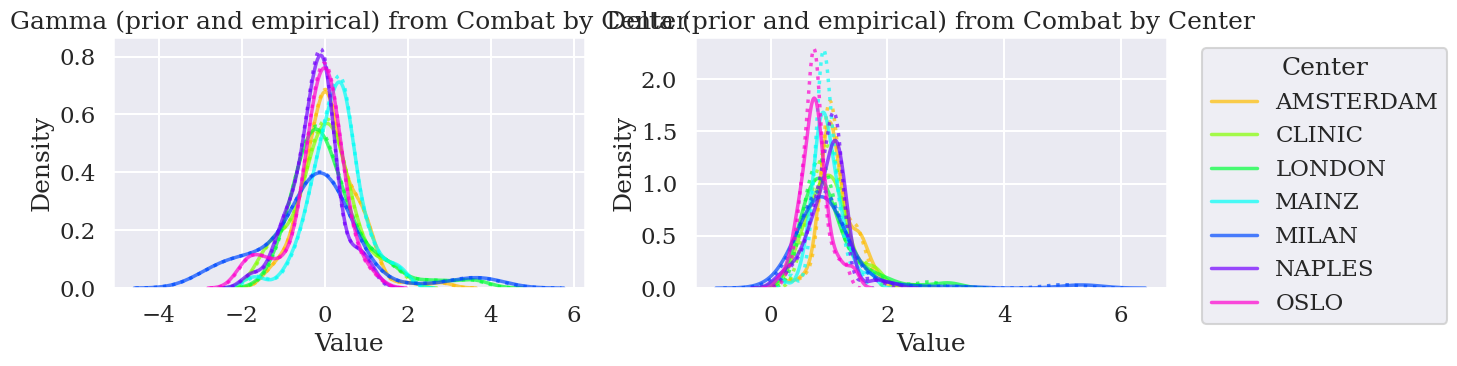

In [6]:
# Print the distribution of gamma star and gamma hat
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

gamma_hat = estimates['gamma_hat']
gamma_star = estimates['gamma.star']

delta_hat = np.array(estimates['delta_hat'])
delta_star = estimates['delta.star']

print(gamma_hat.shape)
print(delta_hat.shape)

sns.set(style="darkgrid", context="talk", palette="turbo", font="serif")

# Create subplot 2x1
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Adjust the size as needed
for (hat, star, title) in [(gamma_hat, gamma_star, 'Gamma'), (delta_hat, delta_star, 'Delta')]:
    curr_ax = axes[0] if title == 'Gamma' else axes[1]
    # Preparing data for plotting
    data = []
    for i in range(hat.shape[0]):
        for arr, style in zip([hat, star], ['solid', 'dotted']):
            # Flatten the array and add to the list with labels
            data.extend([(x, list_of_centers[i], 'Prior' if style is 'solid' else 'Empirical', style) for x in arr[i, :]])

    # Create DataFrame
    df = pd.DataFrame(data, columns=['Value', 'Center', 'Gamma', 'Style'])

    # Plot each group
    palette = sns.color_palette("hsv", n_colors=7)  # A distinct color for each group
    lines = []  # To store the line artists for the legend
    labels = []  # To store labels for the legend
    for (group, array), group_data in df.groupby(['Center', 'Gamma']):
        line = sns.kdeplot(
            data=group_data,
            x='Value',
            hue='Center',  # Colors by group
            palette=[palette[list_of_centers.index(group)]],
            linestyle=group_data['Style'].iloc[0],
            common_norm=False,  # Normalize each distribution separately
            linewidth=2.5,
            alpha=0.7,
            ax=curr_ax,
            legend=False
        )
        if group_data['Style'].iloc[0] == 'solid':
            lines.append(line.lines[-1])  # Get the last line artist from the plot
            labels.append(group)

    curr_ax.set_title(f'{title} (prior and empirical), by Center')

    if title == "Delta":
        plt.legend(handles=lines, labels=labels, title='Center', bbox_to_anchor=(1.05, 1), loc=0)
plt.tight_layout()
plt.show()



Initial length: 730
disease
HC    216
MS    514
dtype: int64
QC N: 5
QC Y: 724
LONDON2: 27


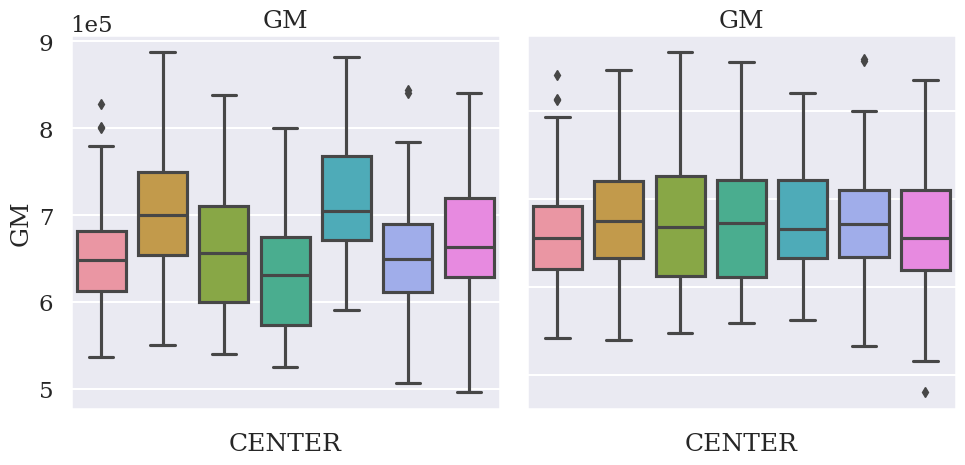

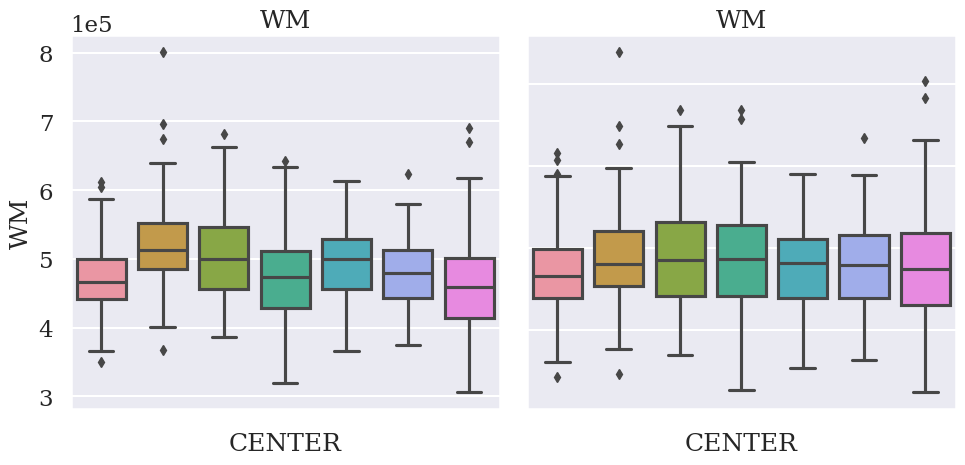

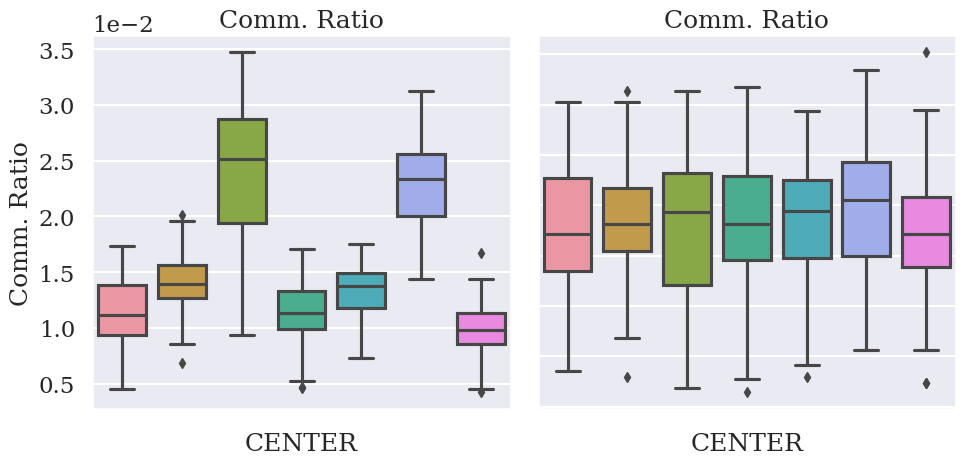

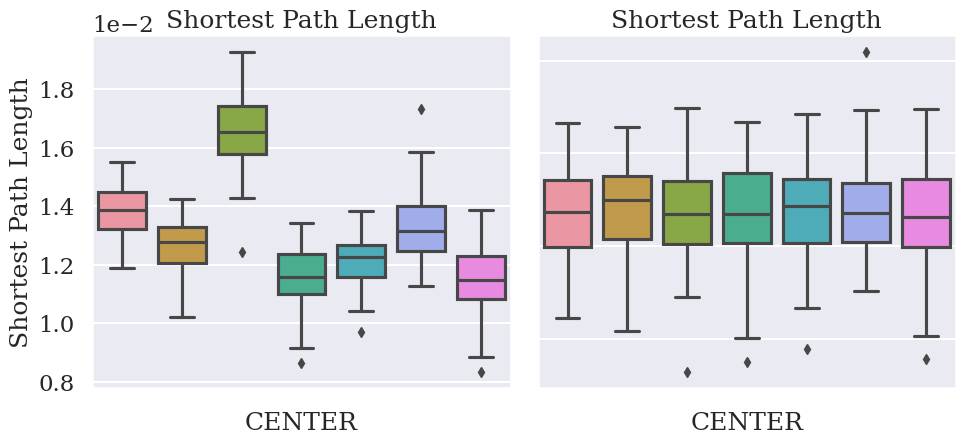

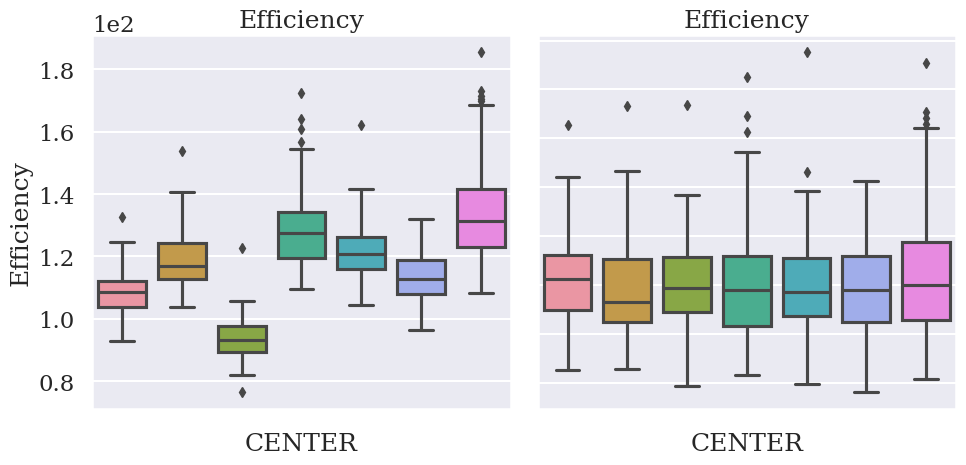

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from scipy.stats import ttest_ind
sns.set(style="whitegrid", context="talk", palette="turbo", font="serif")

# Compare the original data with the data after combat
df_og = load_data()

# Create boxplot for the following features in the list
features_to_compare = ['GM',  'WM', 'Comm. Ratio', 'Shortest Path Length', 'Efficiency']

# Change the name of the features to 
change_name = {
    'GM': 'GM',
    'WM': 'WM',
    'Comm_ratio': 'Comm. Ratio',
    'SC_spl_full': 'Shortest Path Length',
    'SC_eff_full': 'Efficiency'
}

# change name in both og and merged
df_og.rename(columns=change_name, inplace=True)
df_merged.rename(columns=change_name, inplace=True)

# Function to find significant pairs
def find_significant_pairs(data, group_col, value_col):
    centers = data[group_col].unique()
    significant_pairs = []
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            group1 = data[data[group_col] == centers[i]][value_col]
            group2 = data[data[group_col] == centers[j]][value_col]
            t_stat, p_val = ttest_ind(group1, group2)
            if p_val < 0.05:  # Only consider significant results
                significant_pairs.append((centers[i], centers[j]))
    return significant_pairs


for feature in features_to_compare:
    # Create two boxplots, one for the original data and one for the data after combat
    # boxplot should compute the feature for each CENTER
    
    # use seaborn
    # Create a figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjust the size as needed

    # Boxplot for original data
    sns.boxplot(ax=axes[0], x='CENTER', y=feature, data=df_og)
    axes[0].set_title(f"{feature}")
    # 90 degrees label x
    # axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
    # Remove xticklabels
    axes[0].set_xticklabels([])

    # Boxplot for data after combat
    sns.boxplot(ax=axes[1], x='CENTER', y=feature, data=df_merged)
    axes[1].set_title(f"{feature}")
    # 90 degrees label x
    # axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
    # Remove xticklabels
    axes[1].set_ylabel('')
    axes[1].set_yticklabels([])
    axes[1].set_xticklabels([])

    # Ytick labels put scientific format
    axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    # Get significant pairs for each dataset
    significant_pairs_og = find_significant_pairs(df_og, 'CENTER', feature)
    significant_pairs_merged = find_significant_pairs(df_merged, 'CENTER', feature)

    # Annotate the first subplot
    annotator = Annotator(axes[0], significant_pairs_og, data=df_og, x='CENTER', y=feature)
    # annotator.configure(test='t-test_ind', text_format='star', loc='inside', verbose=0)
    # annotator.apply_and_annotate()

    # Annotate the second subplot
    if len(significant_pairs_merged) != 0:
        annotator = Annotator(axes[1], significant_pairs_merged, data=df_merged, x='CENTER', y=feature)
        # annotator.configure(test='t-test_ind', text_format='star', loc='inside', verbose=0)
        # annotator.apply_and_annotate()
    # Show the plot with annotations
    plt.tight_layout()
    plt.show()

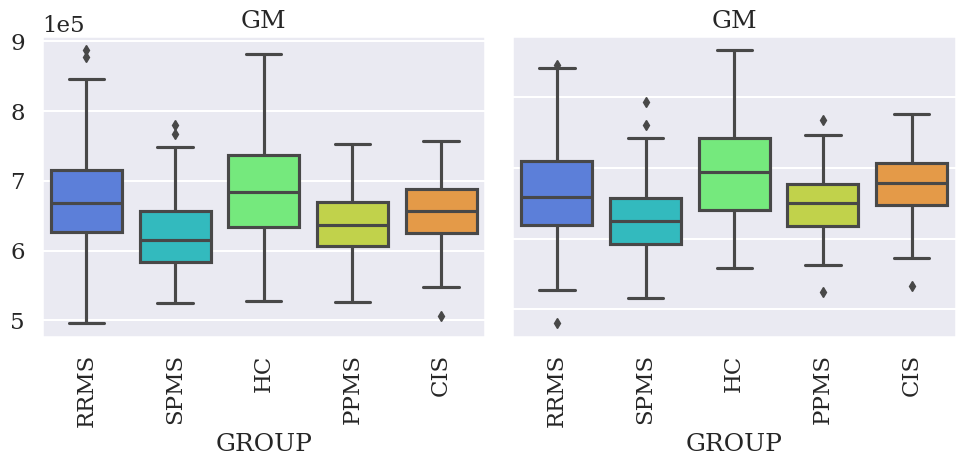

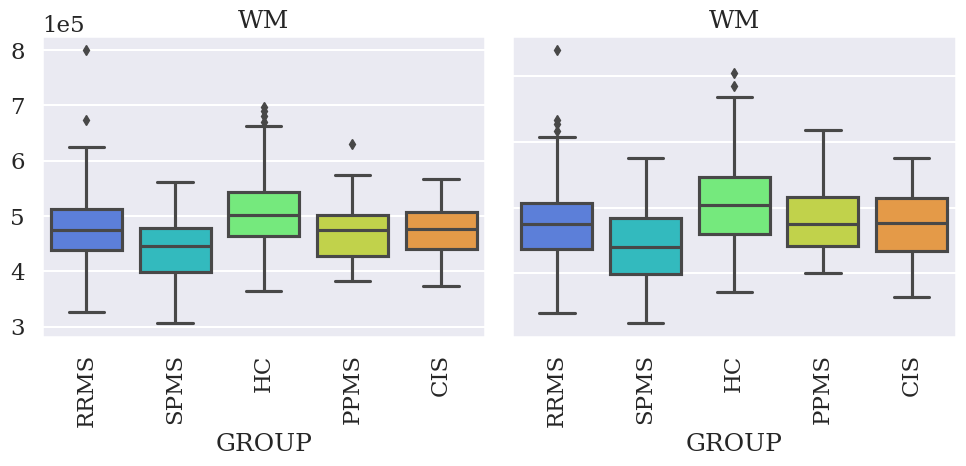

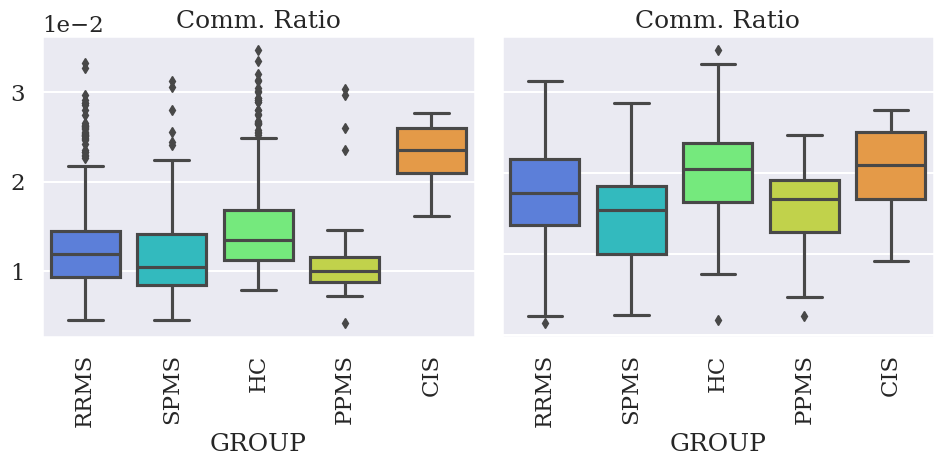

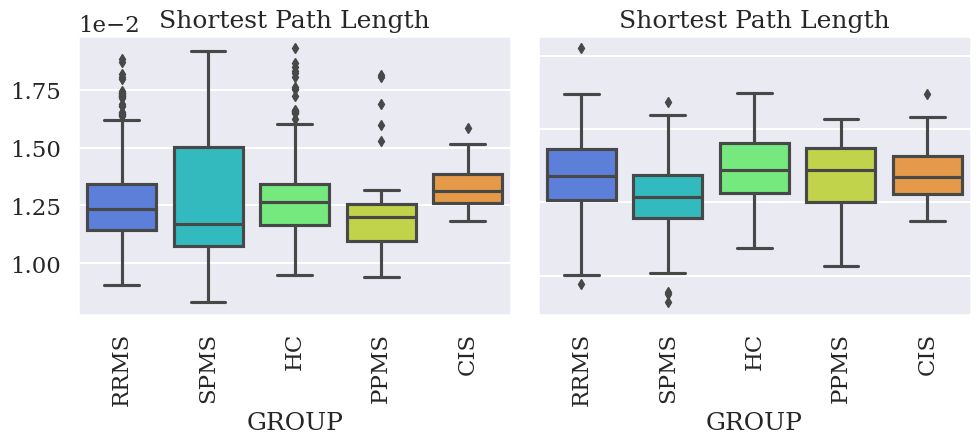

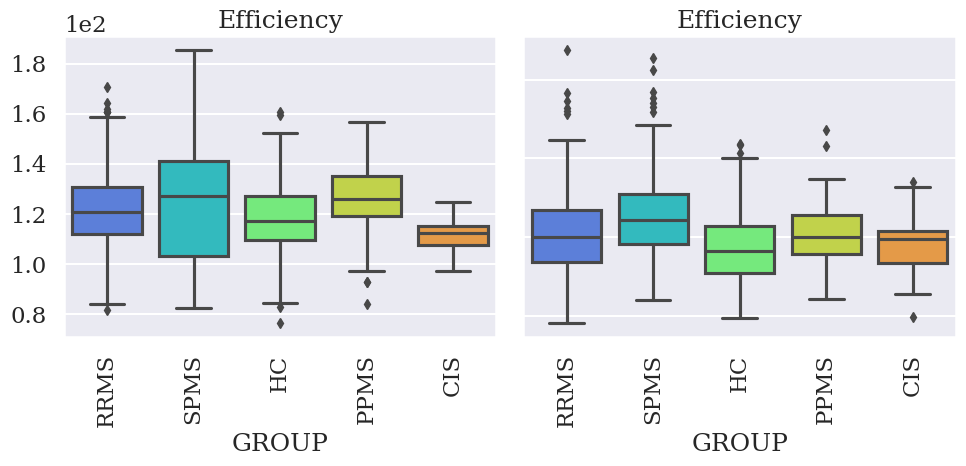

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from scipy.stats import ttest_ind
sns.set(style="darkgrid", context="talk", palette="turbo", font="serif")

# Compare the original data with the data after combat
# df_og = load_data()

# Create boxplot for the following features in the list
features_to_compare = ['GM',  'WM', 'Comm. Ratio', 'Shortest Path Length', 'Efficiency']

# Function to find significant pairs
def find_significant_pairs(data, group_col, value_col):
    centers = data[group_col].unique()
    significant_pairs = []
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            group1 = data[data[group_col] == centers[i]][value_col]
            group2 = data[data[group_col] == centers[j]][value_col]
            t_stat, p_val = ttest_ind(group1, group2)
            if p_val < 0.05:  # Only consider significant results
                significant_pairs.append((centers[i], centers[j]))
    return significant_pairs


for feature in features_to_compare:
    # Create two boxplots, one for the original data and one for the data after combat
    # boxplot should compute the feature for each CENTER
    
    # use seaborn
    # Create a figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjust the size as needed

    # Boxplot for original data
    sns.boxplot(ax=axes[0], x='GROUP', y=feature, data=df_og)
    axes[0].set_title(f"{feature}")
    # 90 degrees label x
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

    # Boxplot for data after combat
    sns.boxplot(ax=axes[1], x='GROUP', y=feature, data=df_merged)
    axes[1].set_title(f"{feature}")
    # 90 degrees label x
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

    # remove y label from the second plot
    axes[0].set_ylabel('')
    axes[1].set_ylabel('')
    axes[1].set_yticklabels([])

    # Ytick labels put scientific format
    axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    # Get significant pairs for each dataset
    significant_pairs_og = find_significant_pairs(df_og, 'GROUP', feature)
    significant_pairs_merged = find_significant_pairs(df_merged, 'GROUP', feature)

    if len(significant_pairs_og) != 0:
        # Annotate the first subplot
        annotator = Annotator(axes[0], significant_pairs_og, data=df_og, x='GROUP', y=feature)
        # annotator.configure(test='t-test_ind', text_format='star', loc='inside', verbose=0)
        # annotator.apply_and_annotate()

    # Annotate the second subplot
    if len(significant_pairs_merged) != 0:
        annotator = Annotator(axes[1], significant_pairs_merged, data=df_merged, x='GROUP', y=feature)
        # annotator.configure(test='t-test_ind', text_format='star', loc='inside', verbose=0)
        # annotator.apply_and_annotate()
    # Show the plot with annotations
    plt.tight_layout()
    plt.show()

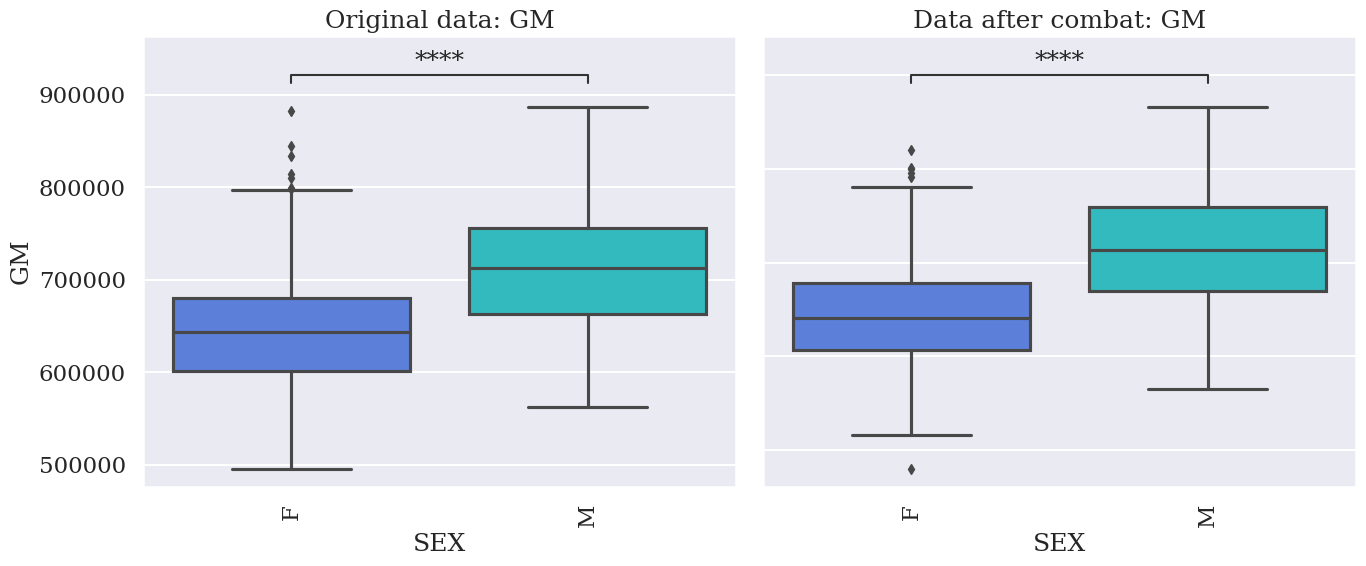

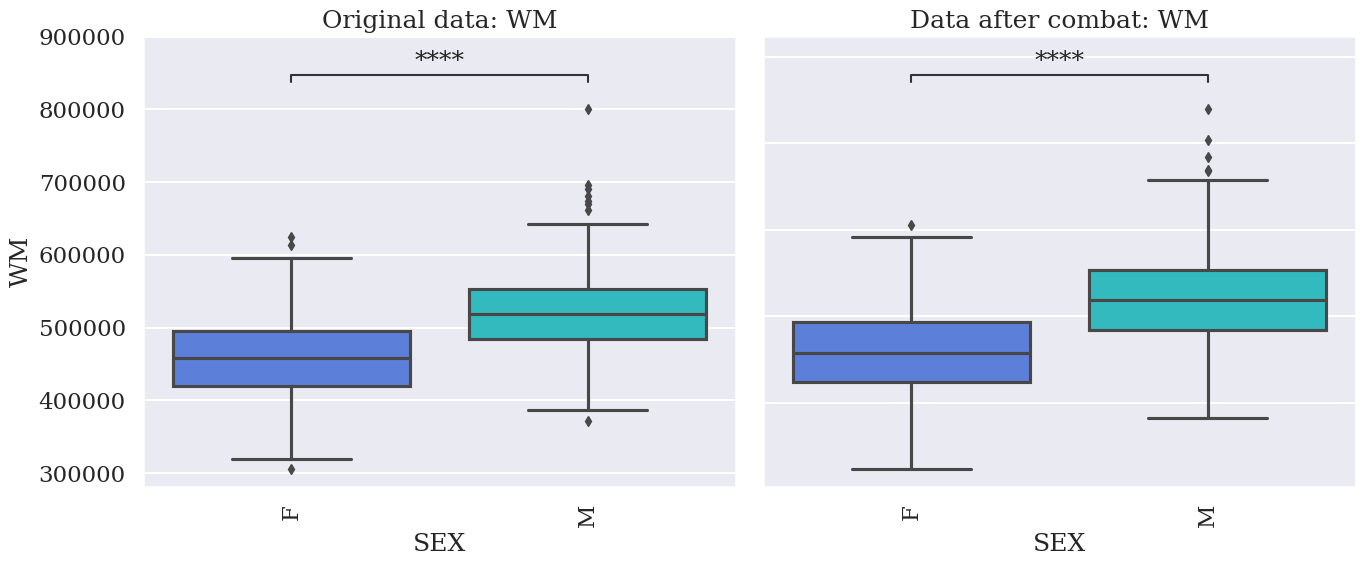

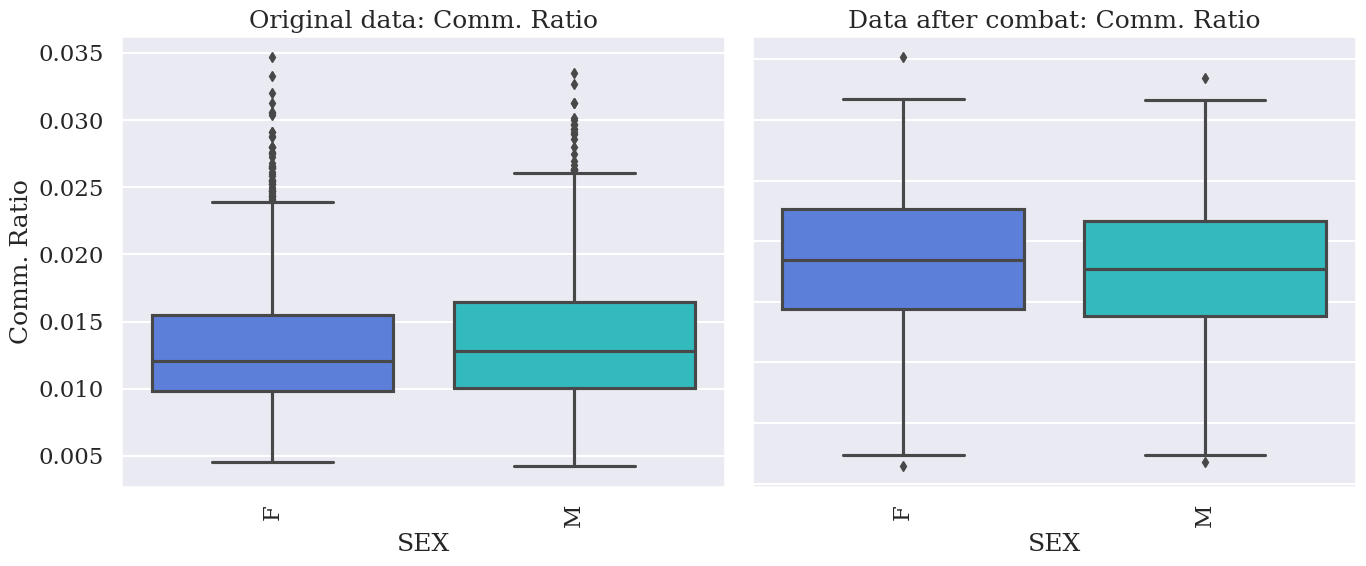

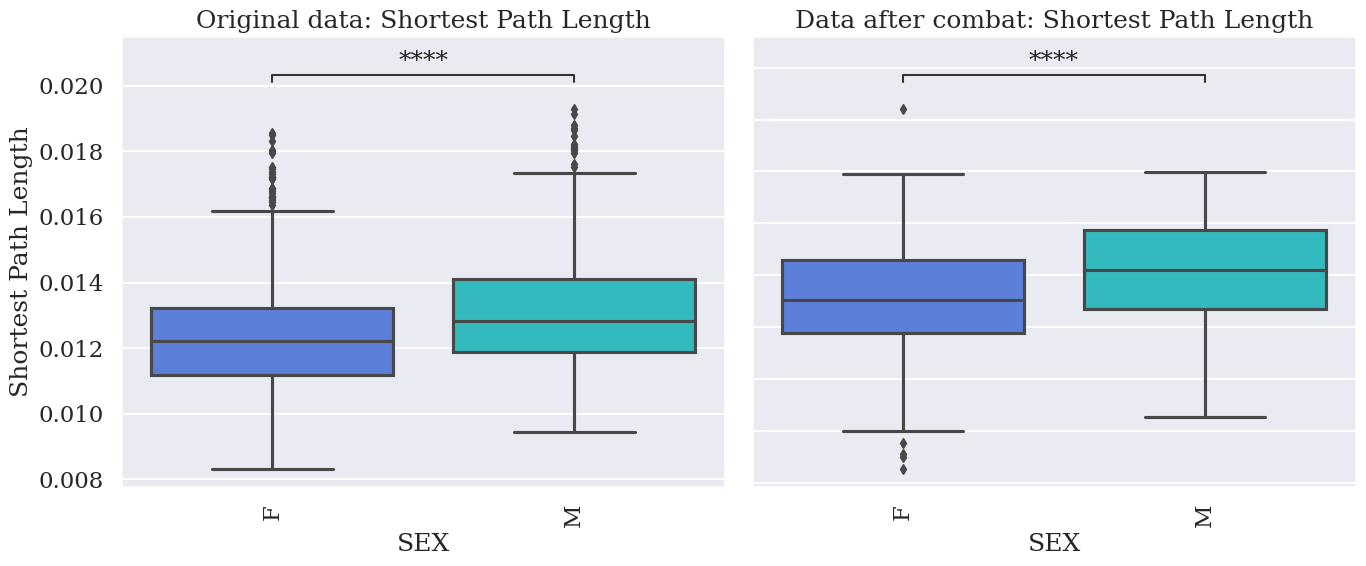

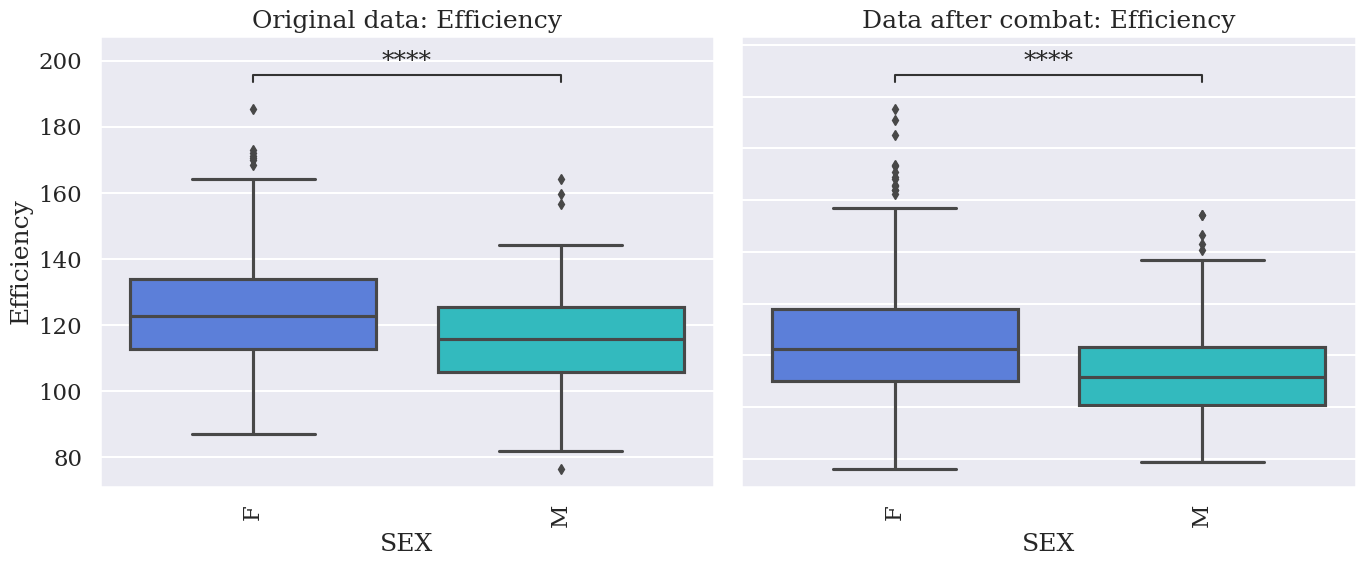

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from scipy.stats import ttest_ind

# Create boxplot for the following features in the list
features_to_compare = ['GM',  'WM', 'Comm. Ratio', 'Shortest Path Length', 'Efficiency']

# Function to find significant pairs
def find_significant_pairs(data, group_col, value_col):
    centers = data[group_col].unique()
    significant_pairs = []
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            group1 = data[data[group_col] == centers[i]][value_col]
            group2 = data[data[group_col] == centers[j]][value_col]
            t_stat, p_val = ttest_ind(group1, group2)
            if p_val < 0.05:  # Only consider significant results
                significant_pairs.append((centers[i], centers[j]))
    return significant_pairs


for feature in features_to_compare:
    # Create two boxplots, one for the original data and one for the data after combat
    # boxplot should compute the feature for each CENTER
    
    # use seaborn
    # Create a figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjust the size as needed

    # Boxplot for original data
    sns.boxplot(ax=axes[0], x='SEX', y=feature, data=df_og)
    axes[0].set_title(f"Original data: {feature}")
    # 90 degrees label x
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

    # Boxplot for data after combat
    sns.boxplot(ax=axes[1], x='SEX', y=feature, data=df_merged)
    axes[1].set_title(f"Data after combat: {feature}")
    # 90 degrees label x
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

    # remove y label from the second plot
    axes[1].set_ylabel('')
    axes[1].set_yticklabels([])

    # Get significant pairs for each dataset
    significant_pairs_og = find_significant_pairs(df_og, 'SEX', feature)
    significant_pairs_merged = find_significant_pairs(df_merged, 'SEX', feature)
    
    if len(significant_pairs_og) != 0:
        # Annotate the first subplot
        annotator = Annotator(axes[0], significant_pairs_og, data=df_og, x='SEX', y=feature)
        annotator.configure(test='t-test_ind', text_format='star', loc='inside', verbose=0)
        annotator.apply_and_annotate()

    # Annotate the second subplot
    if len(significant_pairs_merged) != 0:
        annotator = Annotator(axes[1], significant_pairs_merged, data=df_merged, x='SEX', y=feature)
        annotator.configure(test='t-test_ind', text_format='star', loc='inside', verbose=0)
        annotator.apply_and_annotate()
    # Show the plot with annotations
    plt.tight_layout()
    plt.show()

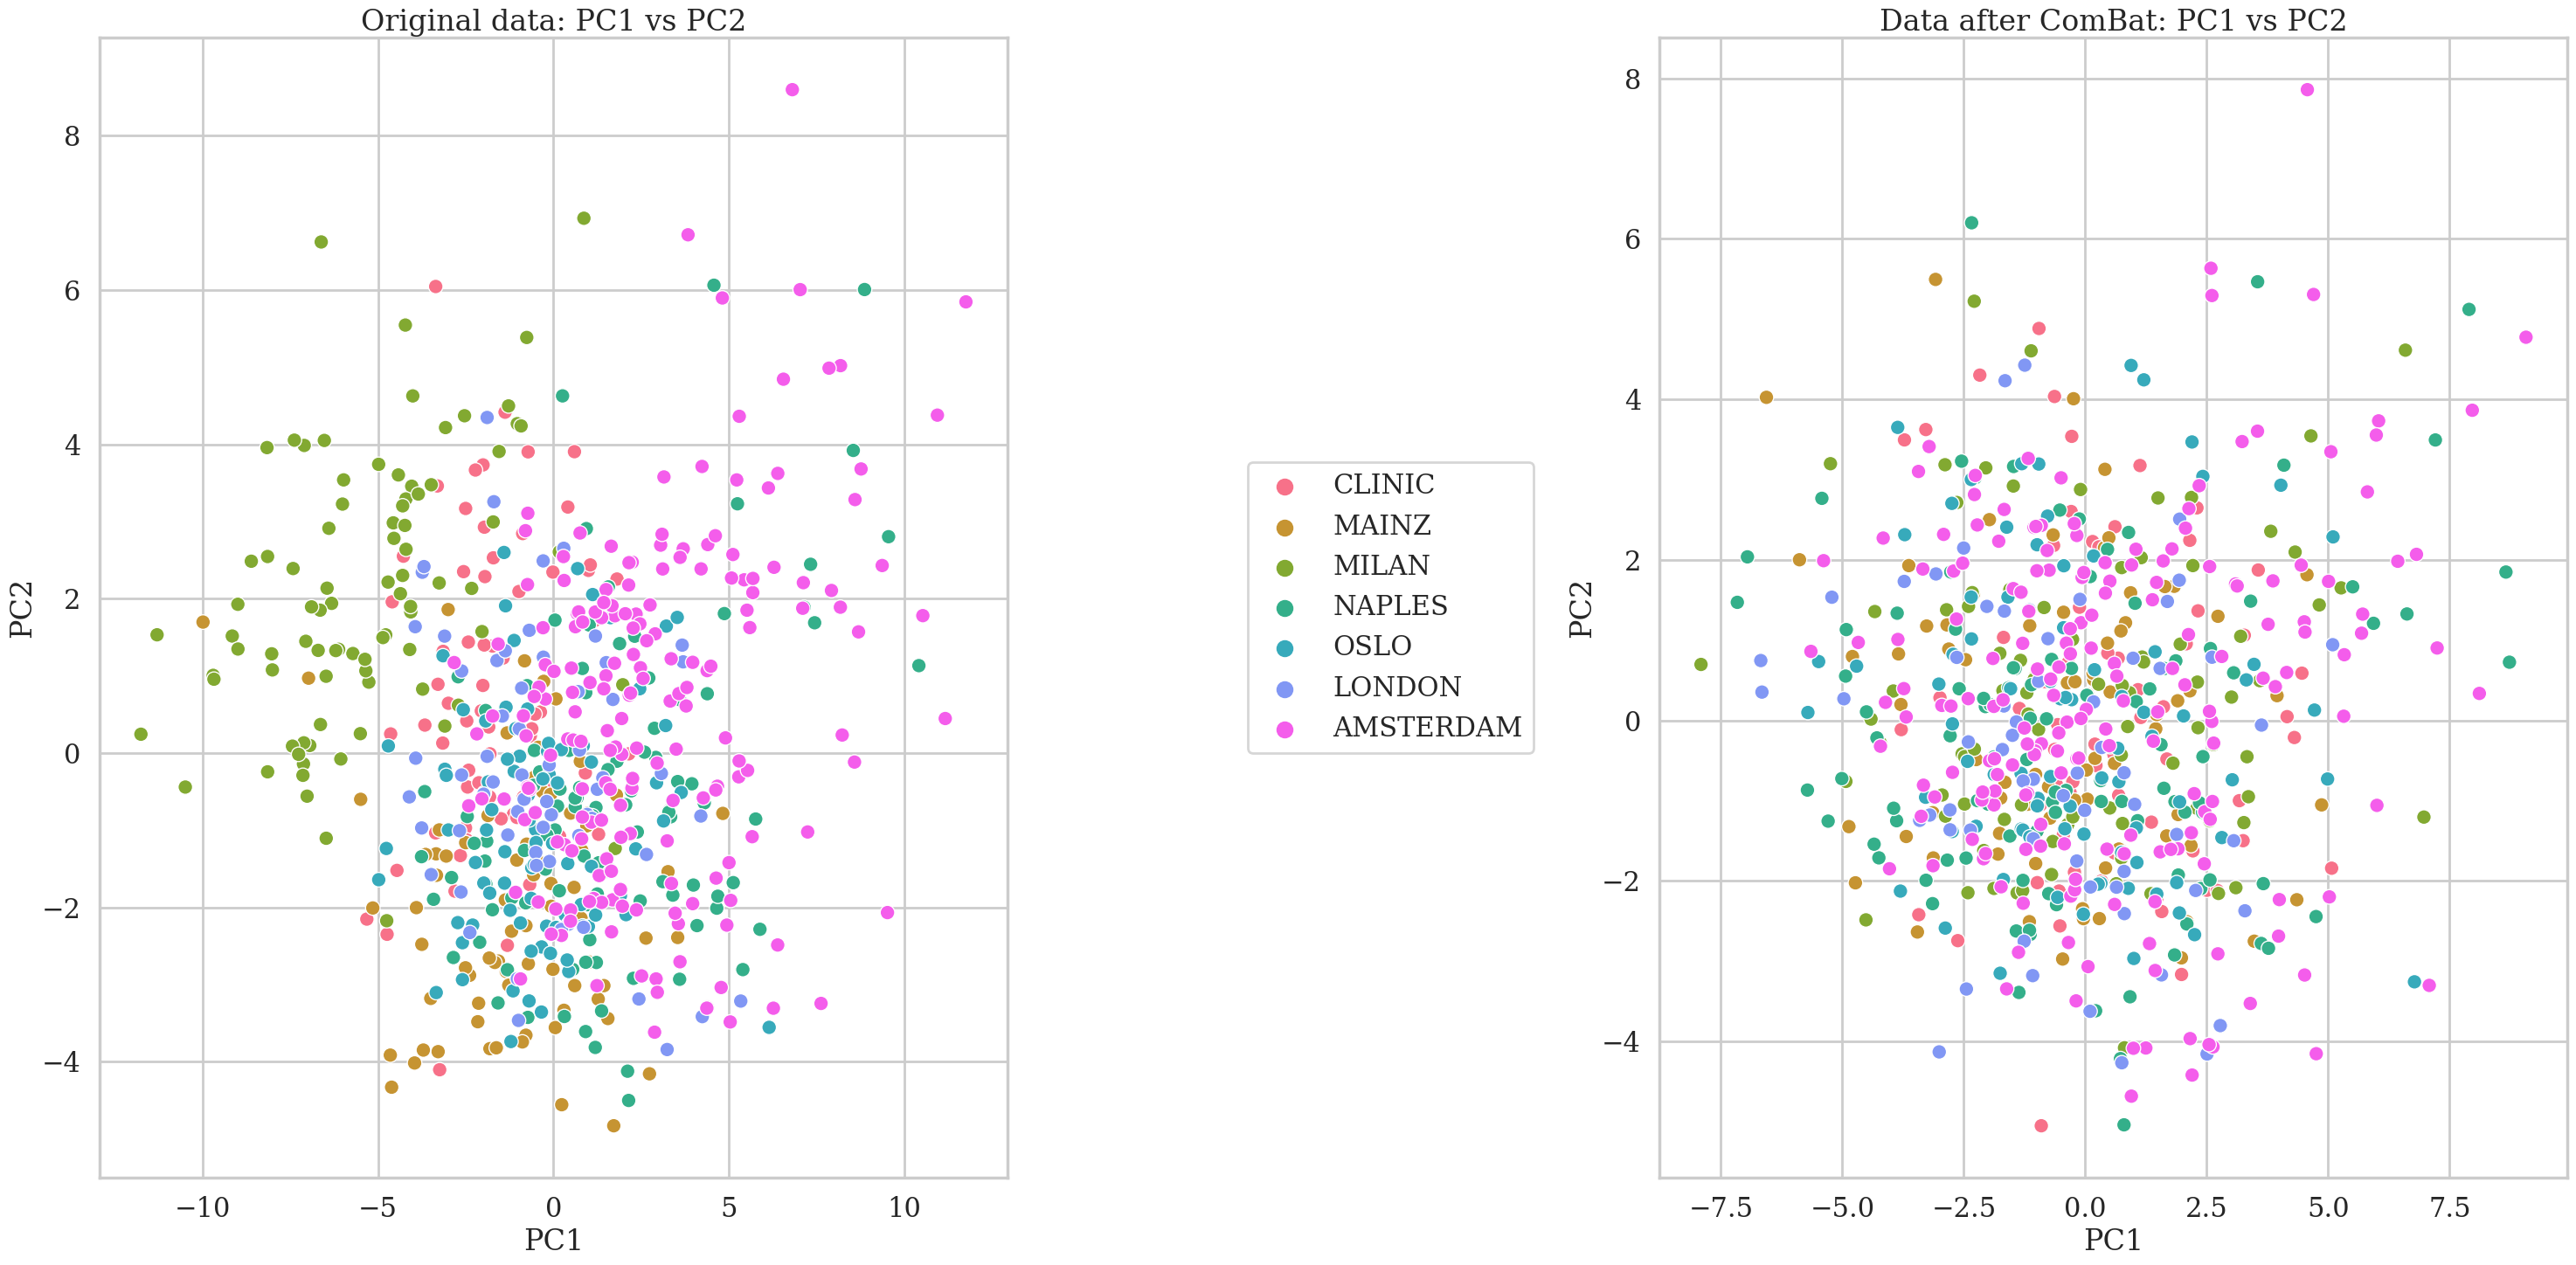

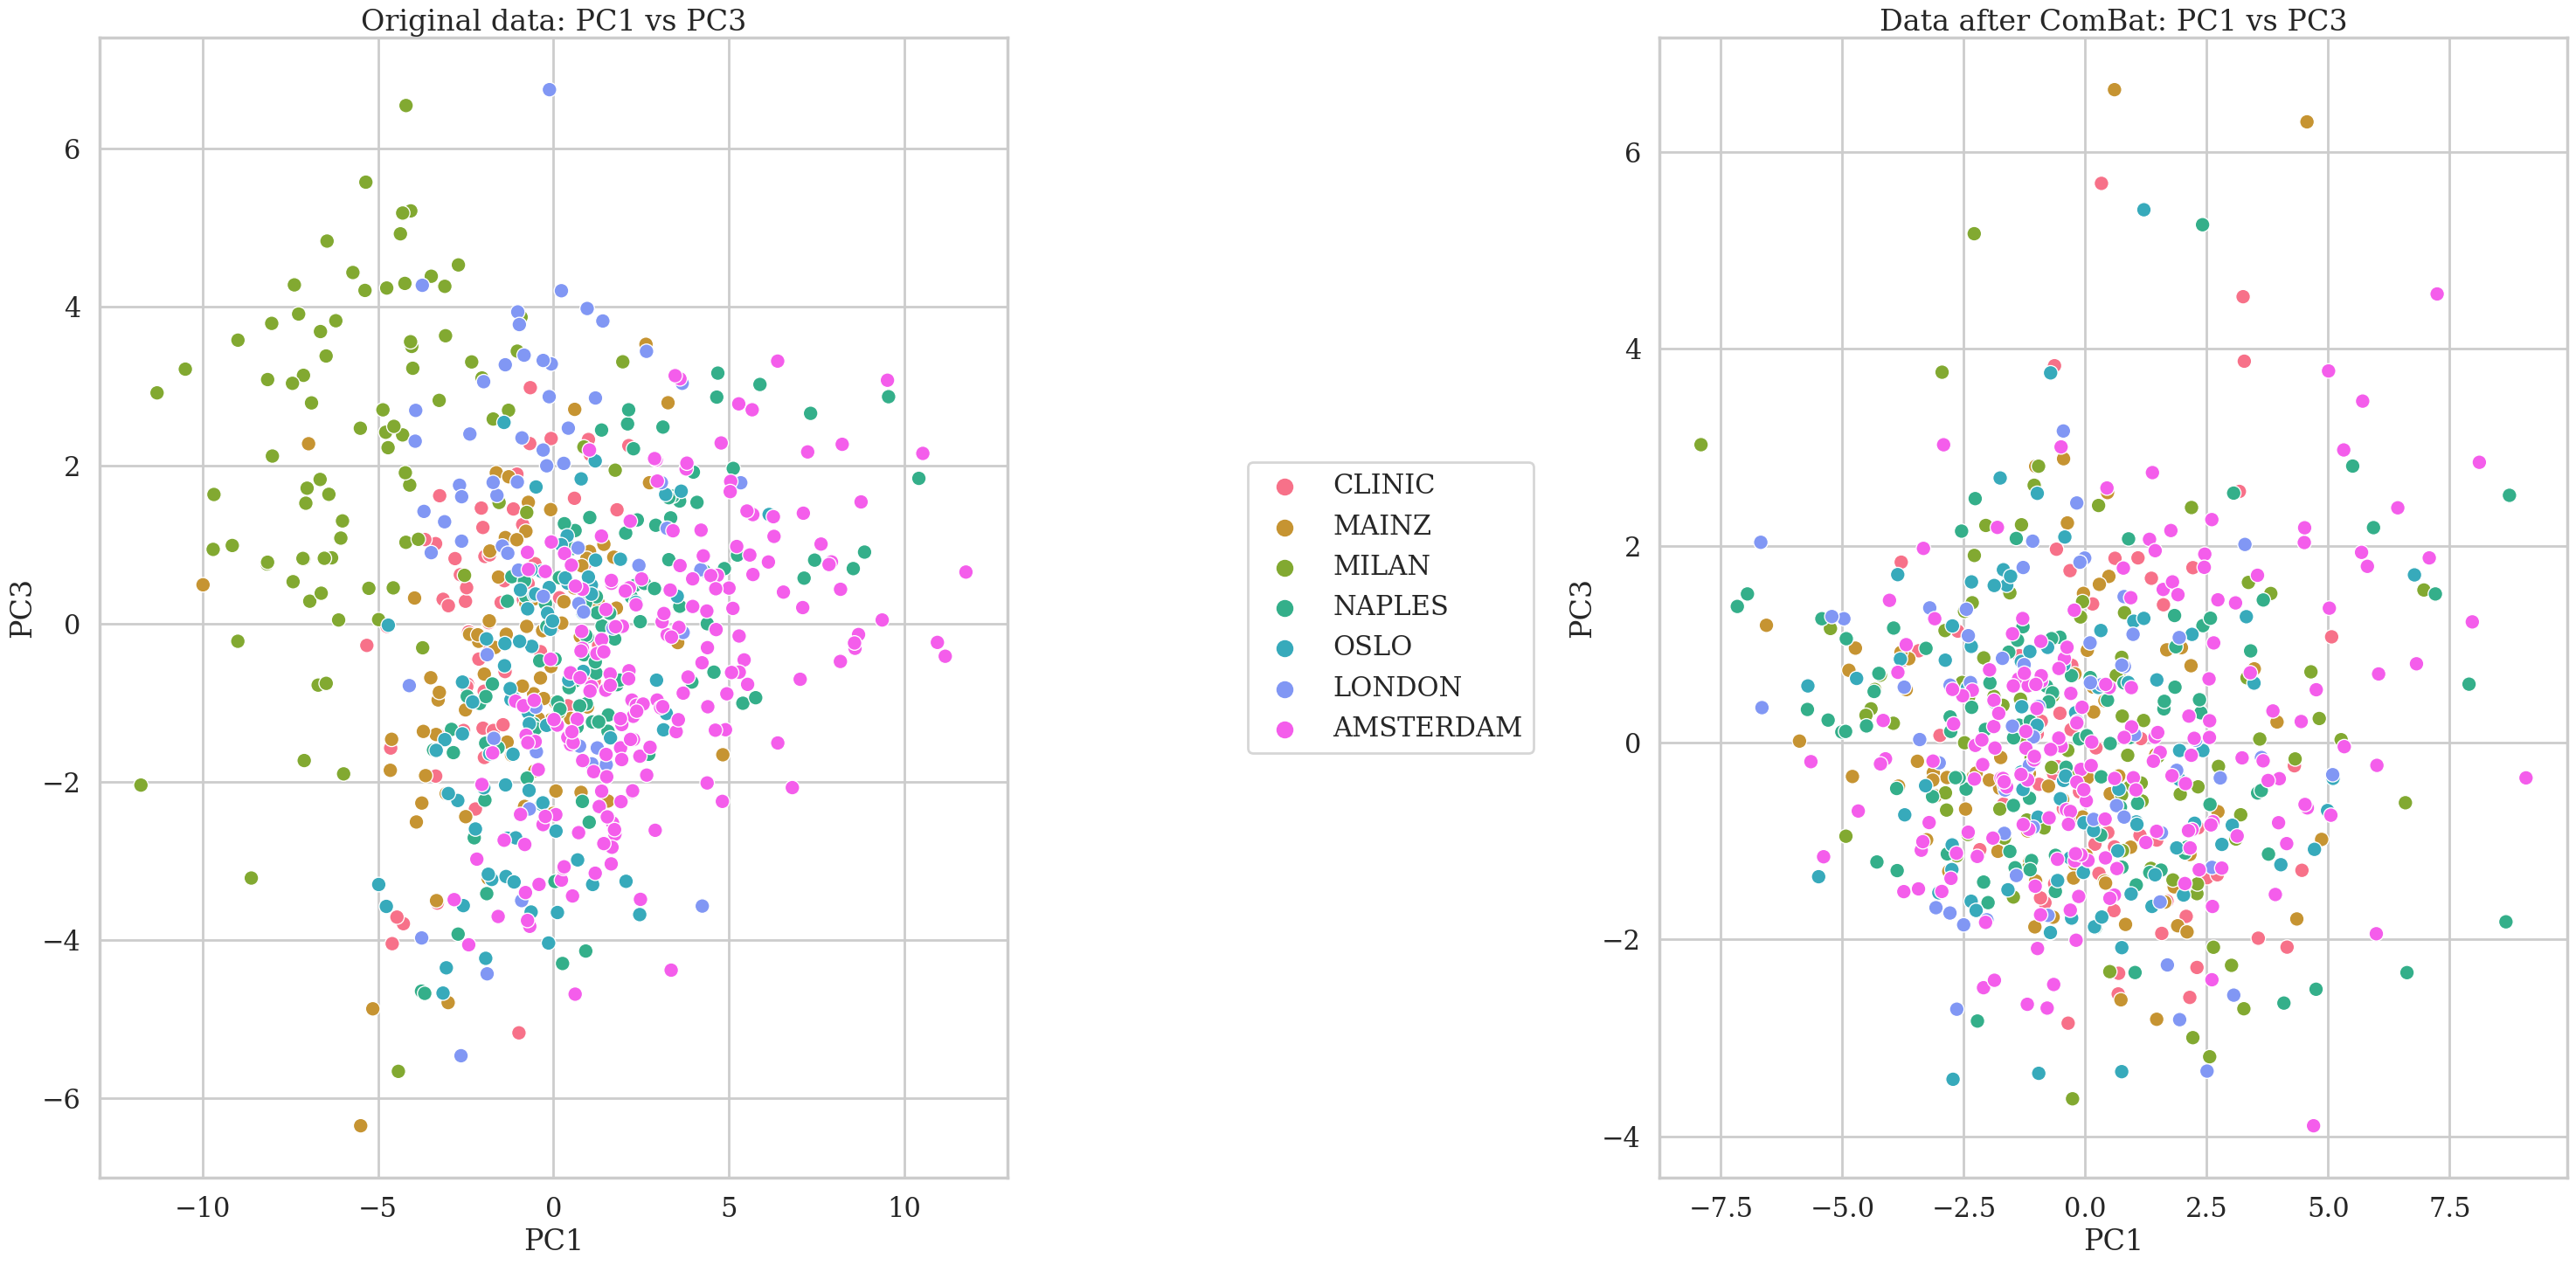

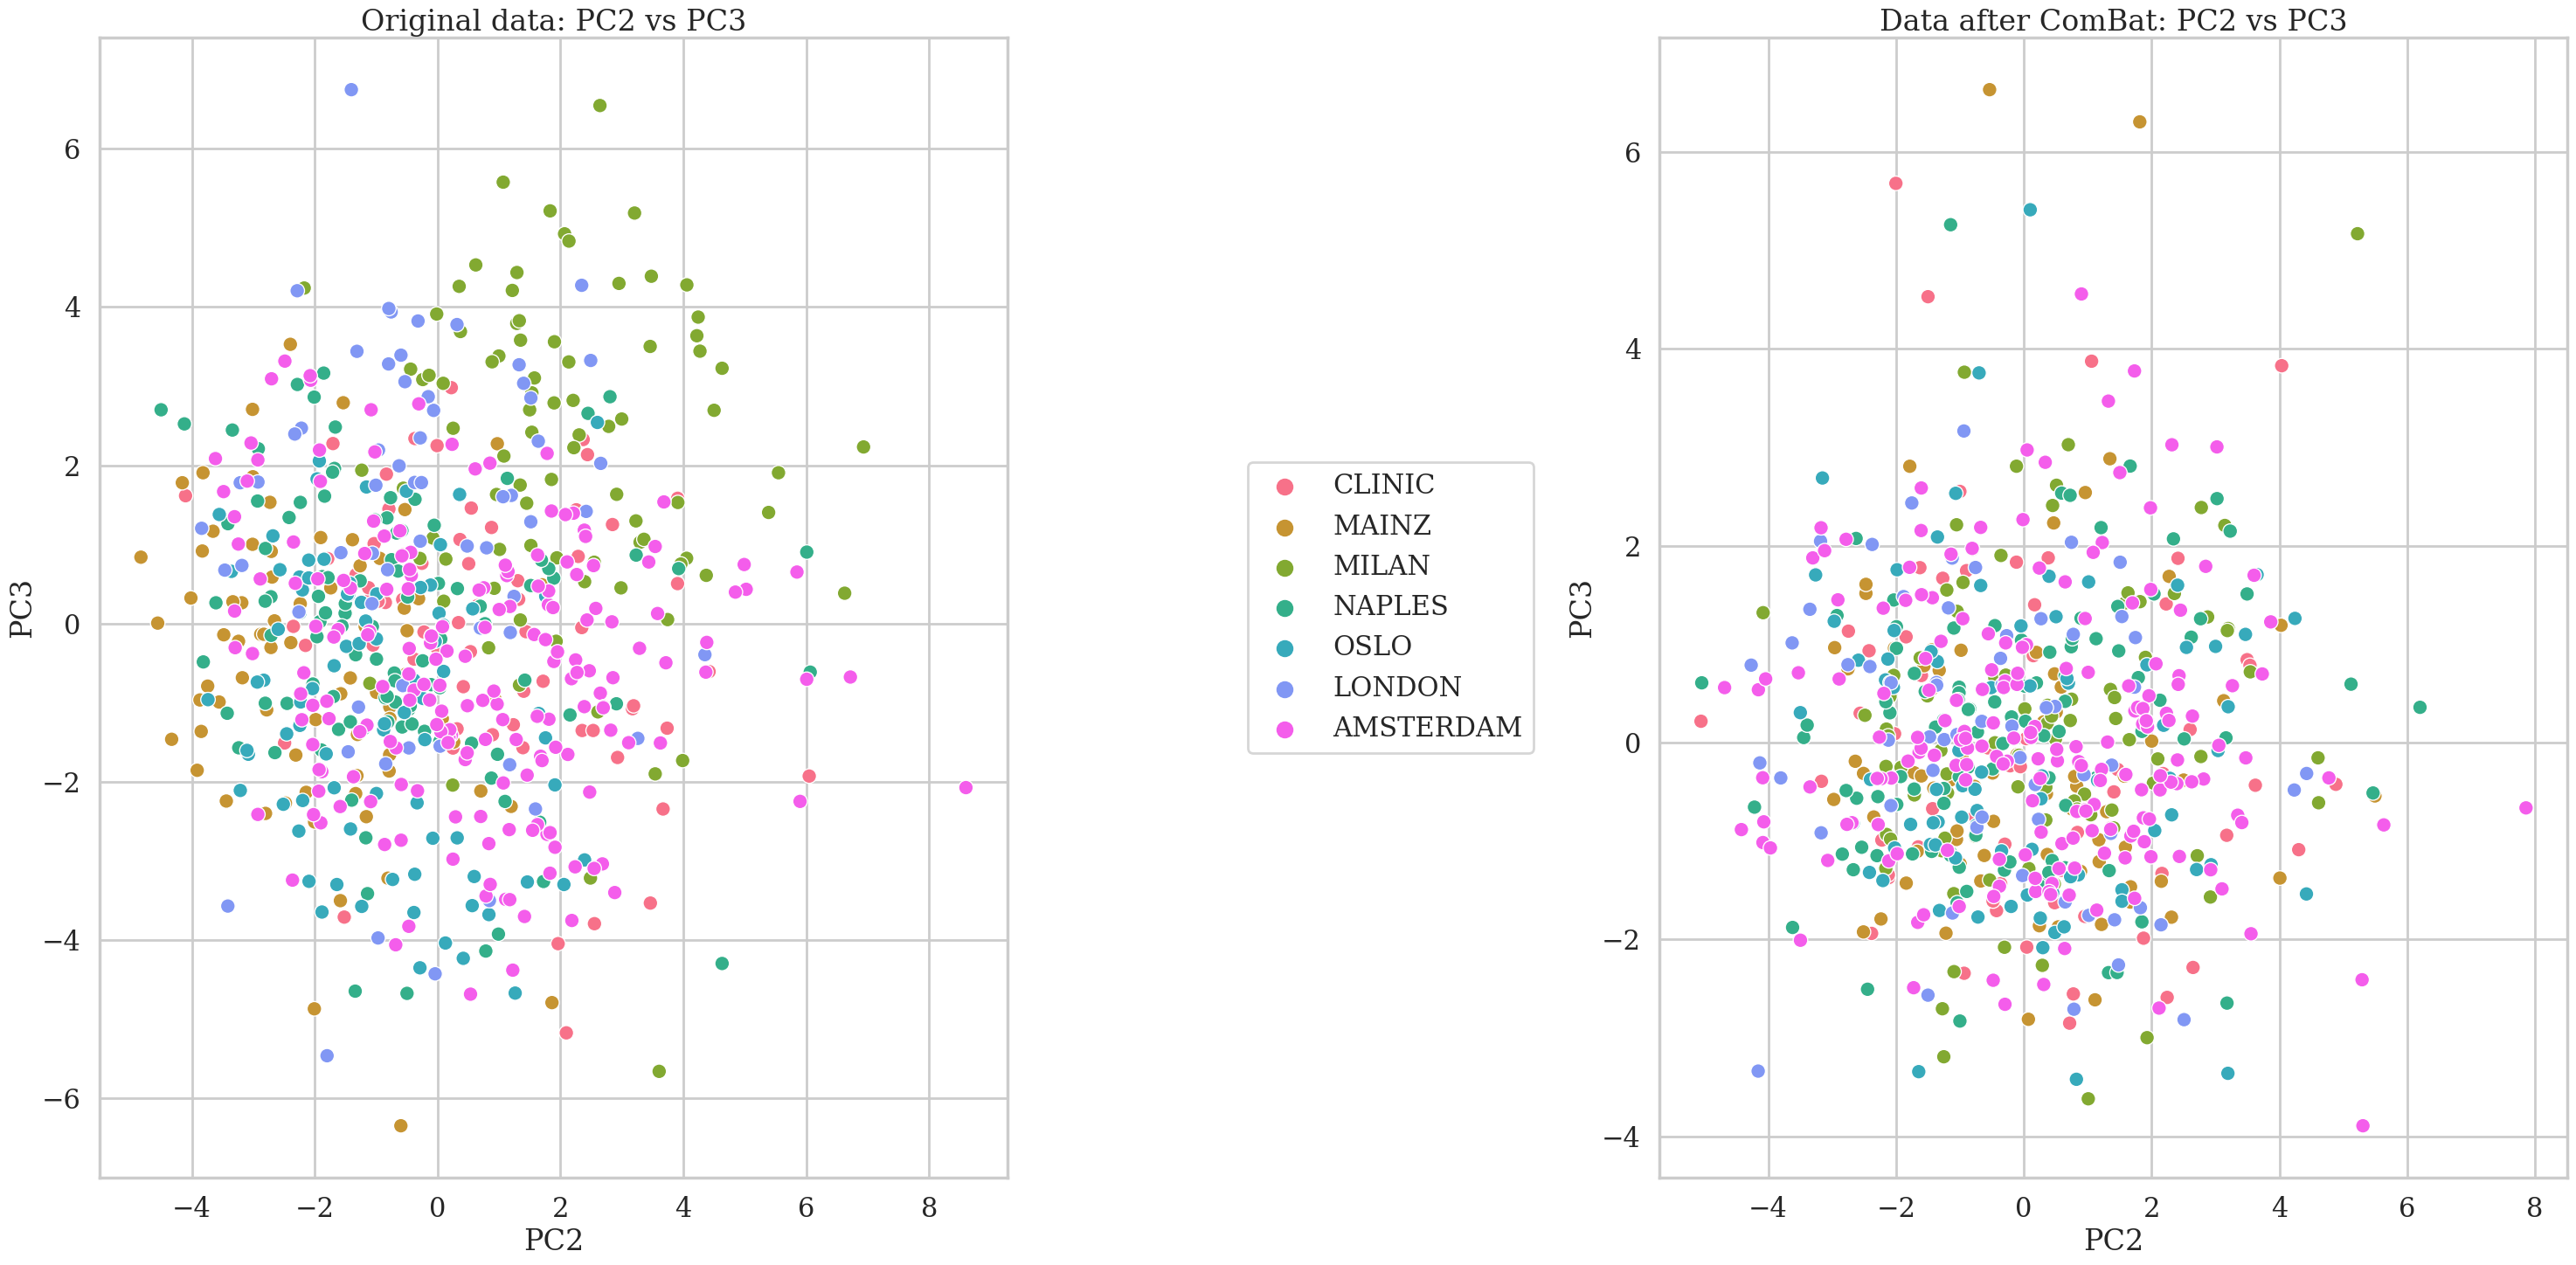

In [61]:
# Create boxplot for the following features in the list
features_to_compare = ['GM',  'WM', 'CSF', 'BPF', 'RDwm_mean', 'CC_Sag_area','EstimatedTotalIntraCranialVol', 'Comm. Ratio', 'SC_avg_spl', 'SC_avg_eff', 'Shortest Path Length', 'Efficiency', 'Full_CC', 'Comm_ratio_approx', 'CC_ratio_area', 'CC_Sag_area_sqrt', 'TIV_cubicroot']
sns.set(style="darkgrid", context="talk", palette="turbo", font="serif")

# Do PCA of the following features, colored by CENTER
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set(style="whitegrid", context="poster", palette="turbo", font="serif")


# Standardize the data
scaler = StandardScaler()
data = df_merged[features_to_compare]
data_scaled = scaler.fit_transform(data)

# Perform PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(data_scaled)

# Create a DataFrame with the principal components, with CENTER
df_pca = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3'])
df_pca['CENTER'] = df_merged['CENTER']

# Repeat the same for df_og
data_og = df_og[features_to_compare]
data_og_scaled = scaler.transform(data_og)

# Perform PCA
pca_og = PCA(n_components=3)
principalComponents_og = pca_og.fit_transform(data_og_scaled)

# Create a DataFrame with the principal components, with CENTER
df_pca_og = pd.DataFrame(data=principalComponents_og, columns=['PC1', 'PC2', 'PC3'])
df_pca_og['CENTER'] = df_og['CENTER']

# For each pair of Principal components, create a subplot comparing the original data with the data after combat
for (pc1, pc2) in itertools.combinations(['PC1', 'PC2', 'PC3'], 2):
    # Create a figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(30, 15))  # Adjust the size as needed

    # Scatter plot for original data
    g = sns.scatterplot(ax=axes[0], x=pc1, y=pc2, hue='CENTER', data=df_pca_og, legend='full')
    g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    axes[0].set_title(f"Original data: {pc1} vs {pc2}")
    
    # Scatter plot for data after combat
    sns.scatterplot(ax=axes[1], x=pc1, y=pc2, hue='CENTER', data=df_pca, legend=False)
    axes[1].set_title(f"Data after ComBat: {pc1} vs {pc2}")

    # Show the plot with annotations
    plt.tight_layout()
    plt.show()

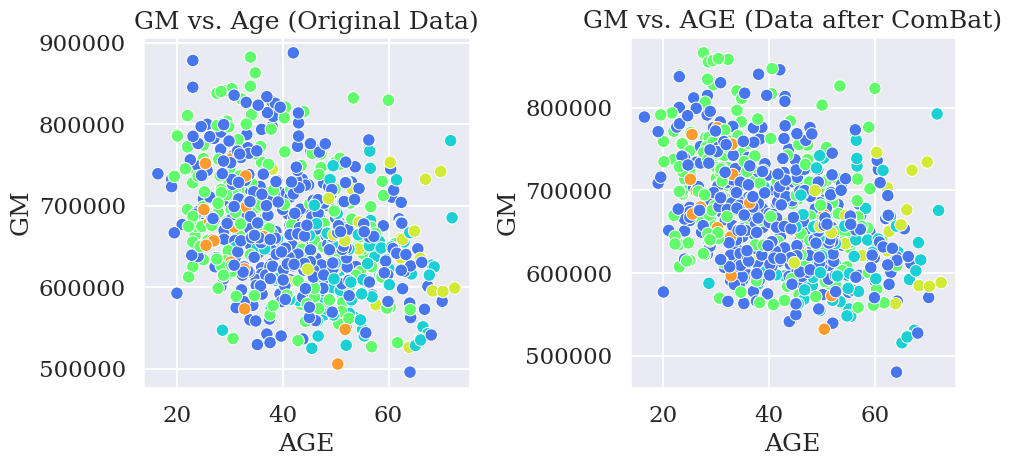

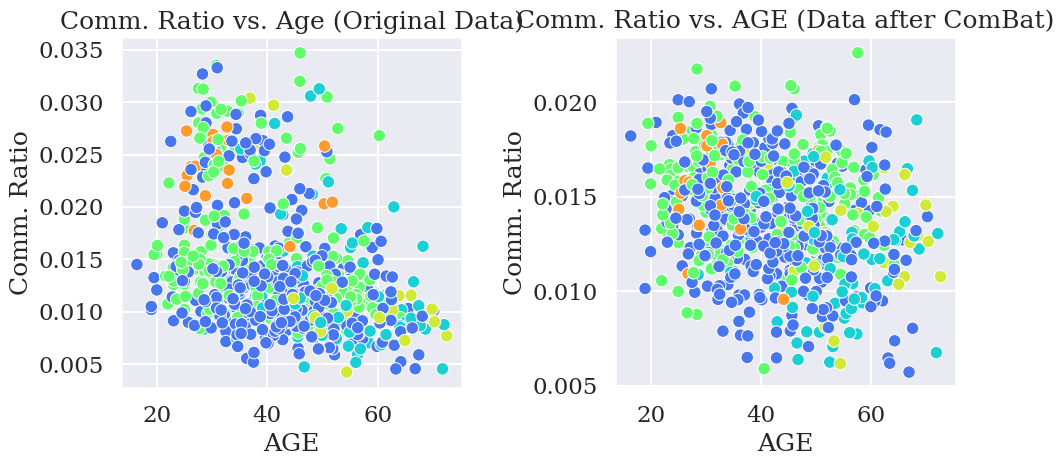

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from scipy.stats import ttest_ind

sns.set(style="darkgrid", context="talk", palette="turbo", font="serif")

# Compare the original data with the data after combat
# df_og = load_data()

# Create boxplot for the following features in the list
features_to_compare = ['GM','Comm. Ratio']

# Create a figure with subplots

# Plotting scatterplots for original data
for feature in features_to_compare:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjust the size as needed

    sns.scatterplot(ax=axes[0], x='AGE', y=feature, hue='CENTER', data=df_og, legend=False)
    axes[0].set_title(f"{feature} vs. Age (Original Data)")

    sns.scatterplot(ax=axes[1], x='AGE', y=feature, hue='CENTER', data=df_merged, legend=False)
    axes[1].set_title(f"{feature} vs. AGE (Data after ComBat)")

    # Adjust layout for better fit
    plt.tight_layout()
    plt.show()